In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
import time

In [2]:
def prepareLowRes(img):
    shape = np.shape(img)
 
    small_img = cv2.resize(img, (int(shape[0]//2),int(shape[1]//2)),interpolation = cv2.INTER_LINEAR)
    return cv2.resize(small_img, shape, interpolation = cv2.INTER_LINEAR)/255
    


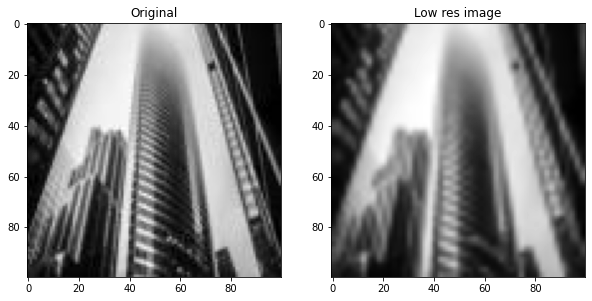

In [3]:
original_img = cv2.cvtColor(cv2.imread(r"C:/Users/Ilan avraham/Downloads/SR/ExampleBased/Buildings-pictures/1.jpg"), cv2.COLOR_BGR2GRAY)/255
lr_img = prepareLowRes(original_img)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1);
plt.imshow(original_img , cmap='gray')
plt.title('Original')
plt.subplot(1,2,2);
plt.imshow(lr_img, cmap='gray')
plt.title('Low res image');

In [4]:
def createPairs(blurry_image, detailed_image):
    sh = np.shape(blurry_image)
    LR = 7
    HR = 5
    LR_half = int(np.floor(LR/2))
    HR_half = int(np.floor(HR/2))
    
    patches_LR = np.zeros((sh[0], sh[1], LR*LR))
    patches_HR = np.zeros((sh[0], sh[1], HR*HR))
    
    for i in range(LR_half, sh[0]-LR_half):
        for j in range(LR_half, sh[1]-LR_half):
            tmp = blurry_image[i-LR_half:i+LR_half+1, j-LR_half:j+LR_half+1]
            tmp2 = detailed_image[i-HR_half:i+HR_half+1, j-HR_half:j+HR_half+1]
            patches_LR[i,j,:] = np.reshape(tmp, LR*LR)
            patches_HR[i,j,:] = np.reshape(tmp2, HR*HR)
            
    patches_LR = np.reshape(patches_LR[3:sh[0]-3, 3:sh[1]-3,:], (-1,LR*LR))
    patches_HR = np.reshape(patches_HR[3:sh[0]-3, 3:sh[1]-3,:], (-1,HR*HR))
    
    return [patches_LR, patches_HR]

 


In [5]:
lr_patches, hr_patches = createPairs(lr_img, original_img)
lr_patches.shape, hr_patches.shape

((8836, 49), (8836, 25))

In [6]:
def createDB(directory):
    keys = []
    values = []
    for filename in os.listdir(directory):
        image_HR = cv2.cvtColor(cv2.imread(directory+filename),cv2.COLOR_BGR2GRAY)/255
        print(np.shape(image_HR))
        sh = np.shape(image_HR)
        image_LR = np.array(prepareLowRes(image_HR))
        HR_detailed = image_HR - image_LR
        
        [LR_patches, HR_patches] = createPairs(image_LR, HR_detailed)
        
        keys.append(LR_patches)
        values.append(HR_patches)
    
    keys = np.concatenate(keys)
    values = np.concatenate(values)
    
    return [np.array(keys), np.array(values)]

In [7]:
from os import path
keys, vals = createDB('./ExampleBased/Buildings-pictures/')
keys.shape, vals.shape

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


((88360, 49), (88360, 25))

In [10]:
def get_high_res_img(low_img, keys, values):
    nbrs = NearestNeighbors(n_neighbors=16, algorithm='kd_tree')
    nbrs.fit(keys)
    patches=[]
    for j in range(3, low_img.shape[0]-3):
        for i in range(3, low_img.shape[1]-3):
 
            patch = low_img[i-3:i+4,j-3:j+4].reshape(49,-1)
            patches.append(patch)
    patches = np.array(patches).reshape(-1,49)

    distance, indexes = nbrs.kneighbors(patches, return_distance=True)

    new_img = values[indexes]
    hr_img = np.zeros(img.shape)

    k=0
    for j in range(3, hr_img.shape[0]-3):
        for i in range(3, hr_img.shape[1]-3):
            hr_img[i-2:i+3,j-2:j+3] = new_img[k][0].reshape(5,5)
            k+=1
  
    return hr_img 

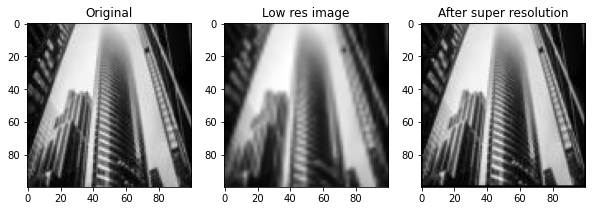

In [11]:
img = cv2.cvtColor(cv2.imread(r"C:/Users/Ilan avraham/Downloads/SR/ExampleBased/Buildings-pictures/1.jpg"), cv2.COLOR_BGR2GRAY)/255
low_img = prepareLowRes(img)
hr_img = get_high_res_img(low_img, keys, vals)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1);
plt.imshow(img , cmap='gray')
plt.title('Original')
plt.subplot(1,3,2);
plt.imshow(low_img, cmap='gray')
plt.title('Low res image');
plt.subplot(1,3,3);
plt.imshow(hr_img, cmap='gray')
plt.title('After super resolution');